<a href="https://colab.research.google.com/github/cdrc1103/DL_Project13e/blob/main/Approach_2_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import itertools
from torch.utils.data import Dataset, DataLoader
import random
import os
from random import randrange

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
import drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing the data for training

In this section we prepare the data for being fed into the model for predictions.

In [3]:
# load the demand data for the intervals of bus line 150 (the data that was prepared beforehand)
demand_link_forth = np.load('drive/MyDrive/deep_proj/Project/Data/demand_link_forth.npy')

# print the first row of intervals' demand
demand_link_forth[1]

array([ 1.,  1.,  2.,  2.,  4., 16., 25., 24., 29.])

In [4]:
# 5786 rows and 9 features (for each interval)
demand_link_forth.shape

(5786, 9)

Next, we scale the data with min-max scaling: (x - min) / (max - min).

In [5]:
demand_link_forth = demand_link_forth.reshape((-1))

min = demand_link_forth.min()
max = demand_link_forth.max()

demand_link_forth = (demand_link_forth - min) / (max - min)
demand_link_forth = demand_link_forth.reshape((5786, 9))

demand_link_forth.shape

(5786, 9)

In [6]:
# scaled data
demand_link_forth

array([[0.        , 0.        , 0.        , ..., 0.01038062, 0.00692042,
        0.00692042],
       [0.00346021, 0.00346021, 0.00692042, ..., 0.08650519, 0.08304498,
        0.10034602],
       [0.00346021, 0.00346021, 0.00692042, ..., 0.10726644, 0.0899654 ,
        0.09688581],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

The demand for public transport hugely depends on both time of the day and day of the week, so we add these two characteristics as features to our samples. These features are sequential and periodic, so we will feed them alongside the other features into our Seq2Seq model.

In [7]:
# load OD-matrix 
od_time = np.load('drive/MyDrive/deep_proj/Project/Data/od_time-202010-150.npy', allow_pickle=True)

# create a pandas dataframe with timestamps for each of 5786 samples
t = pd.DataFrame()
t["timestamp"] = pd.to_datetime(od_time)
t

,timestamp
0,2020-03-01 00:00:00
1,2020-03-01 01:00:00
2,2020-03-01 02:00:00
3,2020-03-01 03:00:00
4,2020-03-01 04:00:00
...,...
5781,2020-10-27 21:00:00
5782,2020-10-27 22:00:00
5783,2020-10-27 23:00:00
5784,2020-10-28 00:00:00


Then, we convert the timestamps to numbers between 0 and 1 (the conversion preserves periodicity of these time-based features). 

In [8]:
# converts part of the day (hour from 0 to 23) to a number from 0 to 1
def partition_day(v):
  hour = v.hour
  # morning
  if 5 <= hour <= 11:
    return 0
  # afternoon
  elif 12 <= hour <= 15:
    return 0.33
  # evening
  elif 16 <= hour <= 22:
    return 0.66
  # night
  else:
    return 1

# converts day of the week to a number from 0 to 1
def partition_week(v):
  day = v.dayofweek
  return day / 6

# apply the conversions to the timestamps
t["day_r"] = t["timestamp"].apply(partition_day)
t["week_r"] = t["timestamp"].apply(partition_week)

t["hour"] = t["timestamp"].apply(lambda x: x.hour)
t["day"] = t["timestamp"].apply(lambda x: x.day)
t["month"] = t["timestamp"].apply(lambda x: x.month)
t["year"] = t["timestamp"].apply(lambda x: x.year)

# drop 'timestamp' column as it's no longer needed
t = t.drop(["timestamp"], axis=1)

In [9]:
# rearrange columns of the dataframe
cols = ['day_r', 'week_r', 'hour', 'day', 'month', 'year']
t = t[cols] 
t.columns

Index(['day_r', 'week_r', 'hour', 'day', 'month', 'year'], dtype='object')

In [10]:
# combine 9 intervals with time features. Now there are 15 features (9 intervals, 
# 'part of the day', 'day of the week', hour, day, month and year). The last 4 
# features are not used for training the model as they are only required for 
# restoring timestamps later when the predictions are generated
demand_link_forth = np.hstack((demand_link_forth, t))
demand_link_forth

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 3.00000000e+00, 2.02000000e+03],
       [3.46020761e-03, 3.46020761e-03, 6.92041522e-03, ...,
        1.00000000e+00, 3.00000000e+00, 2.02000000e+03],
       [3.46020761e-03, 3.46020761e-03, 6.92041522e-03, ...,
        1.00000000e+00, 3.00000000e+00, 2.02000000e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.70000000e+01, 1.00000000e+01, 2.02000000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.80000000e+01, 1.00000000e+01, 2.02000000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.80000000e+01, 1.00000000e+01, 2.02000000e+03]])

In [11]:
# pick an arbitrary sample to check if it looks alright
demand_link_forth[2342]

array([2.42214533e-02, 1.73010381e-02, 2.07612457e-02, 3.46020761e-02,
       6.92041522e-02, 1.62629758e-01, 2.69896194e-01, 2.31833910e-01,
       2.97577855e-01, 3.30000000e-01, 8.33333333e-01, 1.40000000e+01,
       6.00000000e+00, 6.00000000e+00, 2.02000000e+03])

We continue with splitting the data into multiple contiguous sequences with an approach called *sliding window*. The 'window' is moved by 1 hour each time and a new sequence of specified length (`INPUT_SEQ_LEN + OUTPUT_SEQ_LEN`) is added to the resulting dataset. 

In [12]:
# length of the input sequence (168 hours, or 7 days, are used for training the model)
# such length is chosen in order for the model to see the full weekly pattern of data
INPUT_SEQ_LEN = 168

# the prediction of the model covers the next 48 hours after the 168 hours used for training
OUTPUT_SEQ_LEN = 48

In [13]:
# split the data into inputs and labels
x = []
y = []

len_test = OUTPUT_SEQ_LEN
len_train = INPUT_SEQ_LEN
len_n = len_test + len_train

# use sliding window to create multiple sequences of specified length
for i in range(0, demand_link_forth.shape[0] - len_n):
  x.append(demand_link_forth[i:i + len_train])
  y.append(demand_link_forth[i + len_train : i + len_train + len_test])

print("The number of sequences:")
print(len(x))
print(len(y))

The number of sequences:
5570
5570


In [14]:
# randomly shuffle the data
perm = np.random.permutation(len(x))
x = np.array(x)[perm]
y = np.array(y)[perm]

# convert to torch
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

In [15]:
# print the shape of torches
# there are 5570 sequences, each covers 168 hours and contains 15 features (4 of which won't be used for training the model)
print(x.size())
print(y.size())

torch.Size([5570, 168, 15])
torch.Size([5570, 48, 15])


As one of the most important goals of our project is scalability, we have to ensure that training of our model does not take too much time. Thus, we limit the number of samples used for training from 5570 to 150. We take the last `LIMIT_SAMPLES` of those sequences for training (to train the model faster).

In [16]:
LIMIT_SAMPLES = 150

In [17]:
x = x[-LIMIT_SAMPLES:]
y = y[-LIMIT_SAMPLES:]
print("Shapes of inputs and labels:")
print(x.size())
print(y.size())

Shapes of inputs and labels:
torch.Size([150, 168, 15])
torch.Size([150, 48, 15])


Next, we split the data into training, testing and validation sets and create the respective datasets.

In [18]:
# size of training set
n_test = int(x.size()[0] * 0.1)
# size of test and validation set
n_train = x.size()[0] - 2 * n_test

# size of all samples
n = 2 * n_test + n_train

# split the data
x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:n_train + n_test]
y_test = y[n_train:n_train + n_test]

x_val = x[n_train + n_test:]
y_val = y[n_train + n_test:]

print("Train shape:")
print(x_train.shape)
print(y_train.shape)

print("Test shape:")
print(x_test.shape)
print(y_test.shape)

print("Validation shape:")
print(x_val.shape)
print(y_val.shape)

Train shape:
torch.Size([120, 168, 15])
torch.Size([120, 48, 15])
Test shape:
torch.Size([15, 168, 15])
torch.Size([15, 48, 15])
Validation shape:
torch.Size([15, 168, 15])
torch.Size([15, 48, 15])


In [19]:
# dataset class for easier handling of the created datasets
class Dataset(torch.utils.data.Dataset):
  def __init__(self, pairs, labels):
        self.labels = labels
        self.pairs = pairs

  def __len__(self):
        return len(self.pairs)

  def __getitem__(self, index):
        X = self.pairs[index]
        y = self.labels[index]

        return X, y

In [20]:
# training batch size
BATCH_SIZE = 10
# testing batch size
TEST_BATCH_SIZE = 1
# validation batch size
VALIDATION_BATCH_SIZE = 10

# create datasets with the specified batch sizes
training_set = Dataset(x_train, y_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

validation_set = Dataset(x_val, y_val)
validation_generator = torch.utils.data.DataLoader(validation_set, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)

test_set = Dataset(x_test, y_test)
test_generator = torch.utils.data.DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=True)

In order to estimate the amount of time left to train the model, we use the function from PyTorch tutorial on Seq2Seq translation (https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).


In [21]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Defining the Seq2Seq model

In this section we define our Seq2Seq model which consists of Encoder, Decoder and Attention layers.

The Encoder is a simple sequence of LSTM cells.

In [22]:
class EncoderRNN(nn.Module):
    def __init__(self, features, hidden_size_enc, batch_size, num_layers_enc, bidir_enc, dropout):
        super(EncoderRNN, self).__init__()

        self.lstm = nn.LSTM(features, hidden_size_enc, num_layers_enc, batch_first=False, bidirectional=bidir_enc, dropout=dropout)

    def forward(self, input):
        output, hidden = self.lstm(input)
        return output, hidden

The Attention layer should help our model concentrate on more important/relevant parts of the weekly sequence of bus service demand and pay less attention to randomly occuring spikes in demand. The implementation of the layer is based on the Bahdanau attention (https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py, https://arxiv.org/pdf/1409.0473.pdf and https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

In [23]:
class AttentionRNN(nn.Module):
    def __init__(self, batch_size, num_layers_dec, bidir_dec, hidden_size_dec, hidden_size_enc, bidir_enc, input_sequence_len):
        super().__init__()

        self.num_layers_dec = num_layers_dec
        self.bidir_dec = bidir_dec
        self.hidden_size_dec = hidden_size_dec
        self.hidden_size_enc = hidden_size_enc
        self.bidir_enc = bidir_enc
        self.input_sequence_len = input_sequence_len

        if bidir_enc:
          self.fc1 = nn.Linear(hidden_size_dec + hidden_size_enc * 2, hidden_size_dec)
        else:
          self.fc1 = nn.Linear(hidden_size_dec + hidden_size_enc, hidden_size_dec)

        self.fc2 = nn.Linear(hidden_size_dec, 1, bias=False)

    def forward(self, encoder_outputs, hidden):
        # copy the hidden state 'input_sequence_len' times 
        hidden = hidden.repeat(self.input_sequence_len, 1, 1)

        # concatenate all outputs of topmost LSTM layer of Encoder 
        # with the repeated hidden state  
        concat = torch.cat((hidden, encoder_outputs), dim=2)

        # change the dimension of attention output to match Decoder's input and 
        # apply tanh activation function
        energy = torch.tanh(self.fc1(concat))

        # further change the dimension and apply softmax to arrive at the final
        # list of attention weights
        attention = self.fc2(energy).squeeze(dim=2)        
        attention_weight = torch.softmax(attention, dim=0)

        return attention_weight.permute(1,0)

The Decoder receives the output of the Attention layer and hidden state from the Encoder. It uses them to generate a prediction with LSTM cells. 

In [24]:
class DecoderAttentionRNN(nn.Module):
    def __init__(self, features, hidden_size_dec, hidden_size_enc, output_sequence_len, 
                 num_layers_dec, attention, bidir_dec, bidir_enc, dropout):
        super(DecoderAttentionRNN, self).__init__()
        
        self.output_sequence_len = 1
        self.attention = attention

        if bidir_dec:
          self.bidir_dec_coeff = 2
        else:
          self.bidir_dec_coeff = 1

        if bidir_enc:
          self.bidir_enc_coeff = 2
        else:
          self.bidir_enc_coeff = 1

        self.attention_combine = nn.Linear(hidden_size_dec * self.bidir_dec_coeff + hidden_size_enc * self.bidir_enc_coeff, hidden_size_dec * self.bidir_dec_coeff)

        self.lstm = nn.LSTM(hidden_size_dec * self.bidir_dec_coeff, hidden_size_dec, num_layers_dec, batch_first=False, bidirectional=bidir_dec, dropout=dropout)
        
        self.out = nn.Linear(hidden_size_dec * self.bidir_dec_coeff, features)

    def forward(self, input, hidden, encoder_outputs):
        # get the attention weights
        attention = self.attention(encoder_outputs, hidden[0][:1,:,:]).unsqueeze(1)
        
        # use batch multiplication to compute the context vector from 
        # the attention weights and Encoder outputs
        context = torch.bmm(attention, encoder_outputs.permute(1,0,2)).permute(1,0,2)

        # concatenate Decoder's input with the context vector and change the dimension 
        # to match the requirements of LSTM layer 
        input = torch.cat((input, context), dim=2)
        input = self.attention_combine(input)

        # compute the output with LSTM cells
        interm_output, hidden = self.lstm(input, hidden)

        # transform LSTM's output to a vector with the required output dimensions
        output = self.out(interm_output) 

        return output, hidden, interm_output

The Seq2Seq model combines the Encoder, Decoder and Attention in one model. The original input is fed into the Encoder, then the initial attention weights are calculated. Each prediction of the Decoder is fed into the Decoder again (as an input) in order to generate the next prediction. This process is repeated until all 48 predictions are generated (for 48 hours). Attention weights are adjusted with each prediction. 

In [25]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, attention, device, num_layers_enc, num_layers_dec, 
                 teacher_forcing_ratio, batch_size, hidden_size_dec, hidden_size_enc, bidir_enc, bidir_dec, output_sequence_len, features):
        super(Seq2SeqAttention, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.attention = attention
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.bidir_dec = bidir_dec
        self.hidden_size_dec = hidden_size_dec
        self.hidden_size_enc = hidden_size_enc
        self.bidir_enc = bidir_enc

        self.output_sequence_len = output_sequence_len
        self.features = features

        if bidir_dec:
          self.bidir_dec_coeff = 2
        else:
          self.bidir_dec_coeff = 1

        if bidir_enc:
          self.bidir_enc_coeff = 2
        else:
          self.bidir_enc_coeff = 1

        self.device = device
        
    def forward(self, input): 
        batch_size = input.size(1)

        # prepare the array to hold output of the model
        outputs = torch.zeros(self.output_sequence_len, batch_size, self.features).to(self.device)

        # feed input to the Encoder
        encoder_output, encoder_hidden = encoder(input)

        # generate first input to the Decoder (just a matrix of zeros to mark the beginning of an output sequence)
        decoder_input = torch.ones(1, batch_size, self.hidden_size_dec * self.bidir_dec_coeff).to(self.device)
        
        if self.num_layers_dec > 1:
          decoder_hidden = (encoder_hidden[0].repeat(self.num_layers_dec, 1, 1), encoder_hidden[1].repeat(self.num_layers_dec, 1, 1))
        else:
          # Decoder's initial hidden state is the Encoder's last hidden state
          decoder_hidden = encoder_hidden

        # generate output predictions one by one
        for t in range(self.output_sequence_len):
            # generate a single prediction and use it as an input for generating the next predictions
            decoder_output, decoder_hidden, decoder_interm_output = decoder(decoder_input, decoder_hidden, encoder_output)
            decoder_input = decoder_interm_output

            # save the generated prediction
            outputs[t] = decoder_output

        return outputs

# Training the model

In this section we train the model with the data we prepared in the first section.

In [26]:
input_sequence_len = INPUT_SEQ_LEN
output_sequence_len = OUTPUT_SEQ_LEN

batch_size = BATCH_SIZE

# we use 9 intervals, part of the day and day of the week features for 
# working with the model
features = 11

hidden_size_enc = 256
hidden_size_dec = 256

num_layers_enc = 1 # changing this value will break the current model
num_layers_dec = 1 # changing this value will break the current model

bidir_enc = False # turning on will break the current model 
bidir_dec = False # turning on will break the current model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100

teacher_forcing_ratio = 0 # enabling teacher forcing will break the current model 
dropout = 0.2 # is only applied to multilayer LSTMs

# create all the models
encoder = EncoderRNN(features, hidden_size_enc, batch_size, num_layers_enc, bidir_enc, dropout).to(device)
attention = AttentionRNN(batch_size, num_layers_dec, bidir_dec, hidden_size_dec, hidden_size_enc, 
                         bidir_enc, input_sequence_len).to(device)
decoder = DecoderAttentionRNN(features, hidden_size_dec, hidden_size_enc, output_sequence_len, 
                              num_layers_dec, attention, bidir_dec, bidir_enc, dropout).to(device)

model = Seq2SeqAttention(encoder, decoder, attention, device, num_layers_enc, num_layers_dec, 
                         teacher_forcing_ratio, batch_size, hidden_size_dec, hidden_size_enc, 
                         bidir_enc, bidir_dec, output_sequence_len, features).to(device)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


0m 10s (- 3m 23s) (E: 5 5%) TL: 0.03179 VL: 0.02517
0m 21s (- 3m 12s) (E: 10 10%) TL: 0.02853 VL: 0.02435
0m 32s (- 3m 1s) (E: 15 15%) TL: 0.02730 VL: 0.02394
0m 42s (- 2m 51s) (E: 20 20%) TL: 0.02037 VL: 0.01619
0m 53s (- 2m 41s) (E: 25 25%) TL: 0.01371 VL: 0.00953
1m 4s (- 2m 30s) (E: 30 30%) TL: 0.01347 VL: 0.01093
1m 15s (- 2m 20s) (E: 35 35%) TL: 0.01183 VL: 0.00934
1m 26s (- 2m 9s) (E: 40 40%) TL: 0.01018 VL: 0.00844
1m 37s (- 1m 59s) (E: 45 45%) TL: 0.01029 VL: 0.00905
1m 48s (- 1m 48s) (E: 50 50%) TL: 0.00917 VL: 0.00753
1m 59s (- 1m 37s) (E: 55 55%) TL: 0.00767 VL: 0.00767
2m 10s (- 1m 26s) (E: 60 60%) TL: 0.00706 VL: 0.00684
2m 21s (- 1m 15s) (E: 65 65%) TL: 0.00603 VL: 0.00479
2m 32s (- 1m 5s) (E: 70 70%) TL: 0.00389 VL: 0.00313
2m 43s (- 0m 54s) (E: 75 75%) TL: 0.00289 VL: 0.00243
2m 54s (- 0m 43s) (E: 80 80%) TL: 0.00466 VL: 0.00464
3m 5s (- 0m 32s) (E: 85 85%) TL: 0.00349 VL: 0.00275
3m 16s (- 0m 21s) (E: 90 90%) TL: 0.00237 VL: 0.00246
3m 27s (- 0m 10s) (E: 95 95%) TL: 0

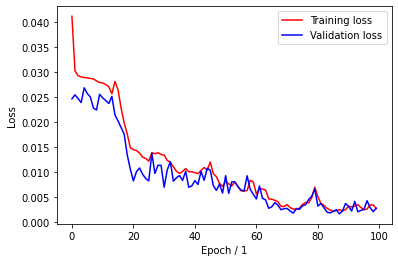

In [27]:
# save losses for printing and plotting
plot_train_losses = []
plot_valid_losses = []

plot_train_loss_total = 0
plot_valid_loss_total = 0

print_train_loss_total = 0
print_valid_loss_total = 0

print_every = 5
plot_every = 1

# we use one optimiser for the whole model instead of separate optimisers for each submodel
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# get the current time to allow printing estimates of time remaining to train the
# model
start = time.time()

for epoch in range(1, epochs + 1):
    # train the model
    model.train()

    skipped_samples = 0
    epoch_loss = 0
    i = 0
    for inputs, labels in training_generator:
      # skip batches that don't have the right batch size
      if len(inputs) != BATCH_SIZE:
        skipped_samples += 1
        continue

      optimizer.zero_grad()
      
      inputs = inputs[:,:,:features].to(device)
      labels = labels[:,:,:features].to(device)

      # feed data into the model
      output = model(inputs.permute(1,0,2))
      output = output.permute(1,0,2)

      loss = criterion(output, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      i += 1

    # store training loss
    train_loss = epoch_loss / (len(training_generator) - skipped_samples)
    plot_train_loss_total += train_loss
    print_train_loss_total += train_loss
    
    # validate the model
    model.eval()

    skipped_samples = 0
    epoch_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_generator:
          # skip batches that don't have the right batch size
          if len(inputs) != VALIDATION_BATCH_SIZE:
              skipped_samples += 1
              continue

          inputs = inputs[:,:,:features].to(device)
          labels = labels[:,:,:features].to(device)

          # feed data into the model
          output = model(inputs.permute(1,0,2)) # don't forget to turn off teacher forcing if it's on 
          output = output.permute(1,0,2)

          loss = criterion(output, labels)
          epoch_loss += loss.item()

    # store validation loss
    valid_loss = epoch_loss / (len(validation_generator) - skipped_samples)
    plot_valid_loss_total += valid_loss
    print_valid_loss_total += valid_loss

    # print losses 
    if epoch % print_every == 0:
        print_train_loss_avg = print_train_loss_total / print_every
        print_valid_loss_avg = print_valid_loss_total / print_every

        print_train_loss_total = 0
        print_valid_loss_total = 0

        print('%s (E: %d %d%%) TL: %.5f VL: %.5f' % (timeSince(start, epoch / epochs),
                                      epoch, epoch / epochs * 100, print_train_loss_avg, print_valid_loss_avg))

    # store losses every 'plot_every' epoch for plotting after the loop terminates
    if epoch % plot_every == 0:
        plot_train_loss_avg = plot_train_loss_total / plot_every
        plot_valid_loss_avg = plot_valid_loss_total / plot_every

        plot_train_losses.append(plot_train_loss_avg)
        plot_valid_losses.append(plot_valid_loss_avg)

        plot_train_loss_total = 0
        plot_valid_loss_total = 0

# plot losses
plt.figure()
plt.plot(plot_train_losses, 'r', label='Training loss')
plt.plot(plot_valid_losses, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch / ' + str(plot_every))
plt.ylabel('Loss')
plt.show() 

# Testing the model

In this section we test how well the trained model performs on the test set. 

First, we define a function that will be used for plotting predictions of our model and real sequences.

In [28]:
convert_day = {
    0 : 'Monday',
    1 : 'Tuesday',
    2 : 'Wednesday',
    3 : 'Thursday',
    4 : 'Friday',
    5 : 'Saturday',
    6: 'Sunday'
}

def plot_compare(width, height, outputs, labels, interval=4, normalised=True, time=None, day=None):
  fig, axs = plt.subplots(figsize=(width,height))
  axs.plot(outputs[0,:,interval], 'b', label='Prediction')
  axs.plot(labels[0,:,interval], 'r', label='Real')
  axs.legend()
  axs.set_xlabel('Time (hour)')

  if normalised:
    axs.set_ylabel('People on the buses in the interval (normalised)')
  else:
    axs.set_ylabel('People on the buses in the interval')

  title = "Interval #" + str(interval)

  axs.set_xticks(np.arange(labels.size()[1]))

  if time is not None and day is not None:
    x_tick_labels = [str(int(i.item())) + ":00" for i in time[0, :]]
    axs.set_xticklabels(x_tick_labels[::4], rotation=90)
    axs.set_xticks(axs.get_xticks()[::4])

    title += " on " + convert_day[round(day[0,0].item() * 6)]
  else:
    axs.set_xticklabels(np.arange(1, labels.size()[1] + 1), rotation=90)

  axs.set_title(title)
  plt.show() 

Then, we test how well the model predicts crowdedness in the 9 intervals. 

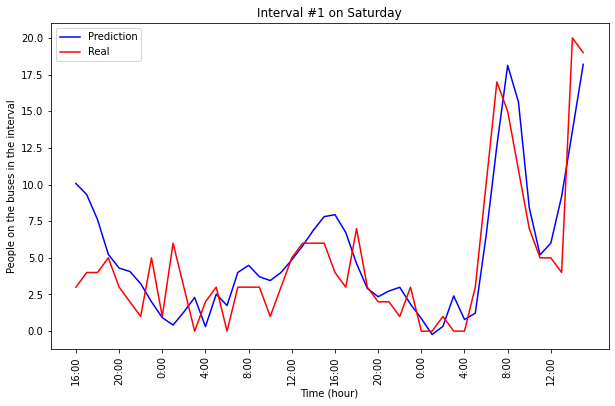

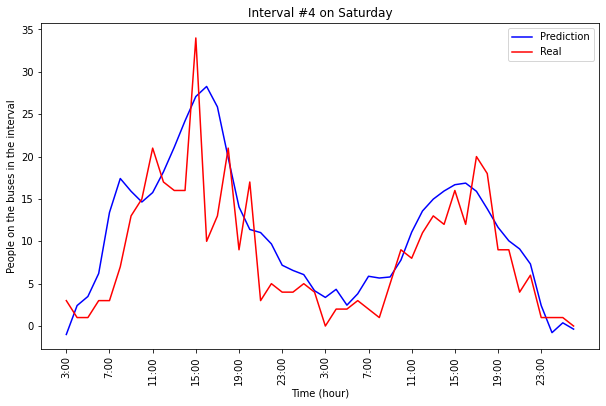

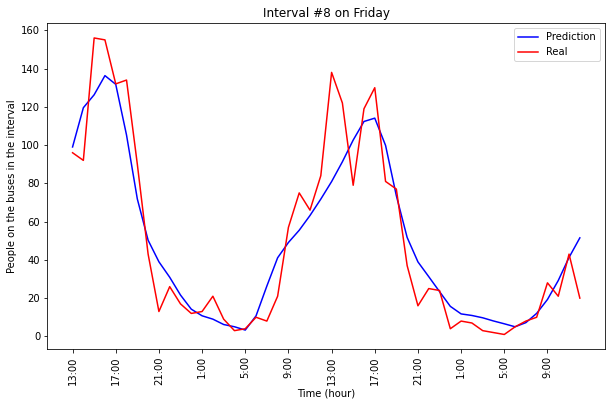

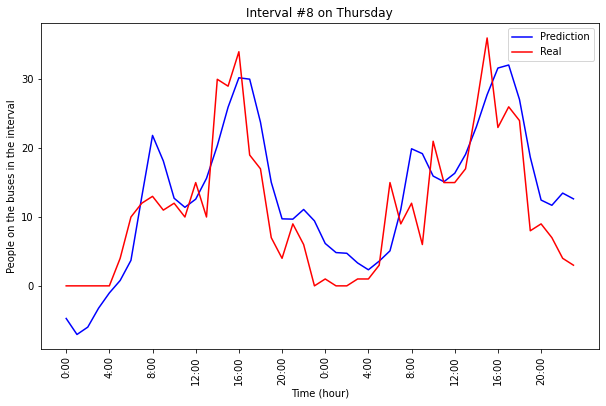

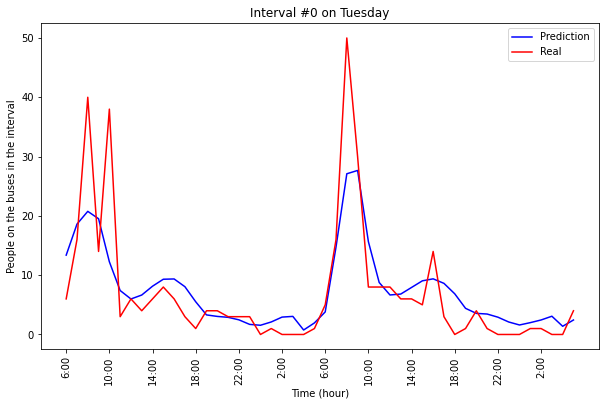

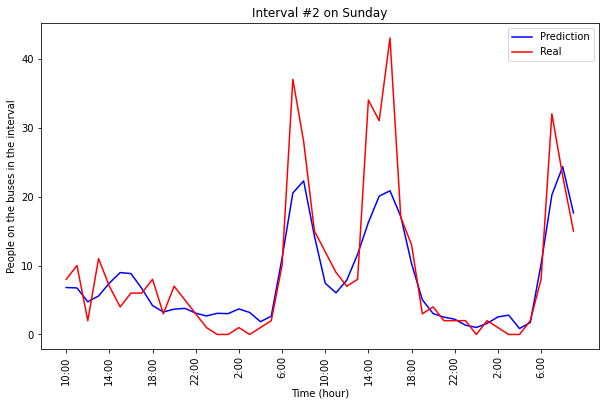

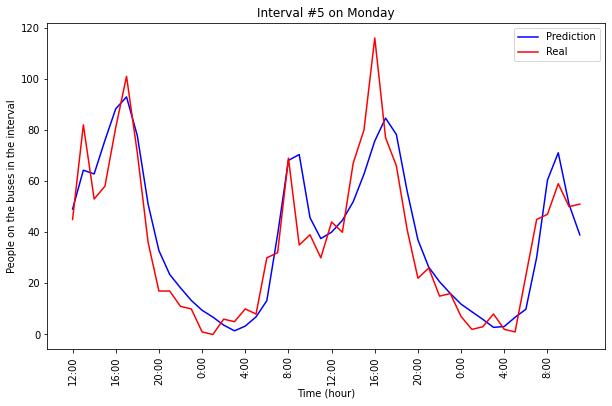

Test loss: 0.0027602576340238255


In [29]:
# test the model
model.eval()

test_loss = 0
sample = 0
with torch.no_grad():
    # plot ~10% of samples
    plot_test_samples = len(test_generator) // 10  

    for inputs, labels in test_generator:
        h = labels[:,:,11]
        d = labels[:,:,12]
        inputs = inputs[:,:,:features].to(device)
        labels = labels[:,:,:features].to(device)

        # feed the testing data into the model
        output = model(inputs.permute(1,0,2)) # don't forget to turn off teacher forcing if it's on 
        output = output.permute(1,0,2)

        if sample == plot_test_samples:
            # denormalise values for plotting
            den_output = output[:,:,:9].cpu().clone().detach()
            den_labels = labels[:,:,:9].cpu().clone().detach()

            # uses min/max values computed in the first section
            den_output = den_output * (max - min) + min
            den_labels = den_labels * (max - min) + min

            # select a random interval and show a plot comparing real and predicted demand
            plot_compare(10, 6, den_output, den_labels, interval=randrange(0,9), normalised=False, time=h, day=labels[:,:,10])

            sample = 0
        else:
          sample += 1
        
        loss = criterion(output, labels)
        test_loss += loss.item()
    
print("Test loss: " + str(test_loss / len(test_generator)))

# Feeding the output of the model to the Rejsekort-to-Total model in order to predict the total demand

In this section we take the output of the model and feed it into the model for prediction the total crowdedness of a bus line based on the number of people using Rejsekort. 

First, we load the trained model that predicts the total demand.

In [42]:
# redefine the Rejsekort-to-Total model class (not the best approach, but the easiest option considering limitations)
class Total(nn.Module):
    def __init__(self):
        super(Total, self).__init__()
        
        self.fc1 = nn.Linear(11, 40)  
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, 9)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
# load the trained model
total_model = Total()
total_model.load_state_dict(torch.load("drive/MyDrive/deep_proj/Project/rejsekort_to_total.pt"))
total_model.eval()

Total(
  (fc1): Linear(in_features=11, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=9, bias=True)
)

In [44]:
# select a single test sample and run the loaded model on it
sample_ind = randrange(0,x_test.size()[0])
one_sample_x = x_test[sample_ind, :, :].to(device).unsqueeze(0)
one_sample_y = y_test[sample_ind, :, :].to(device).unsqueeze(0)

model.eval()
prediction_rejsekort = model(one_sample_x[:,:,:features].permute(1,0,2)).permute(1,0,2)
print("Prediction shape:")
print(prediction_rejsekort.size())

Prediction shape:
torch.Size([1, 48, 11])


In [45]:
# denormalise numbers of passengers in the intervals of the sample
def denormalise(x):
  r = x[:,:,:9].cpu().clone()
  r = r * (max - min) + min

  return torch.cat((r, x.cpu()[:,:,9:]), dim=2)

def separate_week(x):
  x[:,:,10][torch.floor(x[:,:,10] * 6) <= 4] = 0
  x[:,:,10][torch.floor(x[:,:,10] * 6) >= 5] = 1

  return x

timeline = torch.cat((one_sample_x[:,:,11:], one_sample_y[:,:,11:]), dim=1).squeeze(0)

one_sample_x = separate_week(denormalise(one_sample_x)).squeeze(0)
one_sample_y = separate_week(denormalise(one_sample_y)).squeeze(0)

prediction_rejsekort = separate_week(denormalise(prediction_rejsekort)).squeeze(0).detach()

# check if the size of the prediction is correct
one_sample_y.size() 

torch.Size([48, 15])

In [46]:
# process predicted (rejsekort) crowdedness
def process_predicted(x):
  # round negative values to 0 and floats to closest larger integer
  x[:,:9] = torch.absolute(x[:,:9])
  x[:,:9] = torch.ceil(x[:,:9])

  # the Rejsekort-to-Total model requires weekdays to be encoded as 0s and weekends as 1s, so
  # we need to convert the current representation of days (with integers from 0 to 6) to
  # integers 0 and 1
  x[:,9][torch.round(x[:,9] * 3) >= 5] = 1
  x[:,9][torch.round(x[:,9] * 3) < 5] = 0

  return x

prediction_rejsekort = torch.cat((process_predicted(prediction_rejsekort)[:,:11], one_sample_y[:,11:]), dim=1)
prediction_rejsekort[4]

tensor([7.0000e+00, 8.0000e+00, 8.0000e+00, 1.4000e+01, 1.7000e+01, 4.6000e+01,
        7.0000e+01, 5.4000e+01, 6.6000e+01, 0.0000e+00, 1.0000e+00, 1.4000e+01,
        1.6000e+01, 8.0000e+00, 2.0200e+03])

Next, we feed the input to the loaded Rejsekort-to-Total model.

In [47]:
# prepare input to the Rejsekort-to-Total model
input_total = torch.cat((one_sample_x[:,:11], prediction_rejsekort[:,:11]), dim=0)
input_total.size()

torch.Size([216, 11])

In [48]:
# feed input to the loaded model
prediction_total = total_model(input_total)
prediction_total.size()

torch.Size([216, 9])

Finally, we plot the result for a single random interval.

In [49]:
# load names of the timing points and choose a random one for plotting
timing_points = np.load('drive/MyDrive/deep_proj/Project/Data/od_stop-202010-150.npy', allow_pickle=True)
one_interval = randrange(0, 9)
timing_point_a = timing_points[one_interval]
timing_point_b = timing_points[one_interval + 1]

x_plot = one_sample_x[:,one_interval]
y_plot = one_sample_y[:,one_interval]
rejsekort_plot = prediction_rejsekort[:,one_interval]
total_plot = prediction_total[:,one_interval].detach()

# timeline has all the necessary points of time
timeline = timeline.int()
timeline.size()

torch.Size([216, 4])

In [50]:
timeline_df = pd.DataFrame(timeline.cpu().numpy())
timeline_df.columns = ["hour", "day", "month", "year"]
timeline_df = pd.to_datetime(timeline_df)

In [51]:
x_tick_labels = [i.strftime('%H:%M %d-%b-%Y (%a)') for i in timeline_df]
x_tick_labels[:5]

['10:00 09-Aug-2020 (Sun)',
 '11:00 09-Aug-2020 (Sun)',
 '12:00 09-Aug-2020 (Sun)',
 '13:00 09-Aug-2020 (Sun)',
 '14:00 09-Aug-2020 (Sun)']

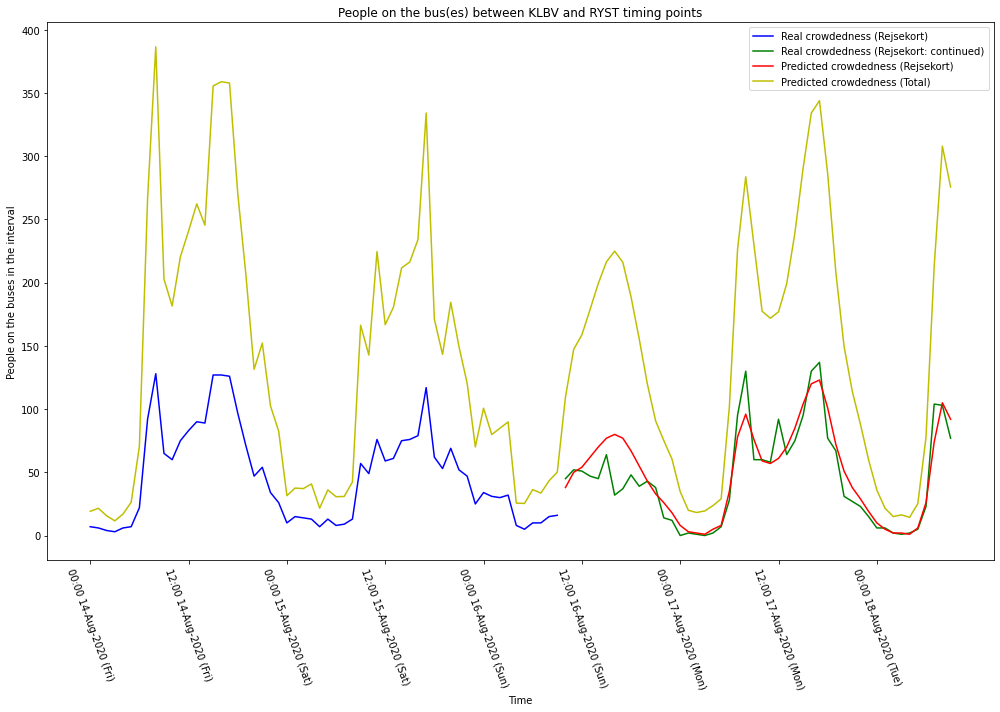

In [53]:
fig, axs = plt.subplots(figsize=(14,10))

start_from_t = 110

axs.plot(np.arange(0, len(x_plot) - start_from_t), x_plot[start_from_t:], 'b', label='Real crowdedness (Rejsekort)')
axs.plot(np.arange(len(x_plot) - start_from_t, len(x_plot) - start_from_t + len(y_plot)), y_plot, 'g', label='Real crowdedness (Rejsekort: continued)')
axs.plot(np.arange(len(x_plot) - start_from_t, len(x_plot) - start_from_t + len(y_plot)), rejsekort_plot, 'r', label='Predicted crowdedness (Rejsekort)')

axs.plot(np.arange(0, len(x_plot) + len(y_plot) - start_from_t), total_plot[start_from_t:], 'y', label='Predicted crowdedness (Total)')

axs.set_ylabel('People on the buses in the interval')
axs.set_xlabel('Time')
axs.legend()
title = "People on the bus(es) between " + str(timing_point_a) + " and " + str(timing_point_b) + " timing points"

every_nth_label = 12
axs.set_xticks(np.arange(0, len(x_tick_labels) - start_from_t, every_nth_label))
axs.set_xticklabels(x_tick_labels[start_from_t::every_nth_label], rotation=-70)

axs.set_title(title)
plt.tight_layout()
# plt.grid()
plt.savefig('drive/MyDrive/deep_proj/Project/Data/final_out.png', dpi=300)
plt.show() 